In [65]:
# Installing yfinance
!pip install yfinance
!pip install quantstats
!pip install pyportfolioopt
!pip install ta 
!pip install pandas_datareader

In [66]:
# Importing Libraries

# Data handling and statistical analysis 
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optimization and allocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman, BlackLittermanModel

# Financial data 
import quantstats as qs
import ta
import yfinance as yf

# Linear Regression Model
from sklearn.linear_model import LinearRegression

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datetime and hiding warnings 
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

In [3]:
AAPL = yf.download('AAPL', start = '2020-01-01')
#AAPL

AMD = yf.download('AMD', start = '2020-01-01')
#AMD

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [38]:
aapl = qs.utils.download_returns('AAPL')
aapl = aapl.loc['2020-01-01':'2024-07-31']
#print(aapl)

amd = qs.utils.download_returns('AMD')
amd = amd.loc['2020-01-01':'2024-07-31']
#print(amd)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# Download data for AAPL and AMD
ticker_aapl = yf.Ticker('AAPL')
ticker_amd = yf.Ticker('AMD')

# Get the latest market cap
market_cap_AAPL = ticker_aapl.info['marketCap']
market_cap_AMD = ticker_amd.info['marketCap']

# Visualize market cap
print(f"Market Cap for AAPL: ${market_cap_AAPL:,}")

# Visualize market cap
print(f"Market Cap for AMD: ${market_cap_AMD:,}")

Market Cap for AAPL: $3,405,870,268,416
Market Cap for AMD: $236,346,638,336


In [6]:
# Example for handling timezone-naive timestamps
if aapl.index.tz is None:
    aapl.index = aapl.index.tz_localize('UTC')  # or your preferred timezone
else:
    aapl.index = aapl.index.tz_convert('UTC')

if amd.index.tz is None:
    amd.index = amd.index.tz_localize('UTC')
else:
    amd.index = amd.index.tz_convert('UTC')

[*********************100%%**********************]  1 of 1 completed



Apple Daily Returns Plot:



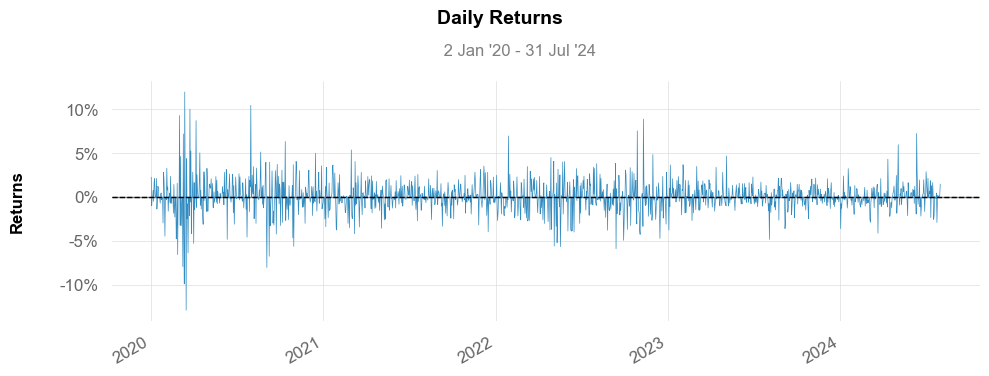


AMD Daily Returns Plot:



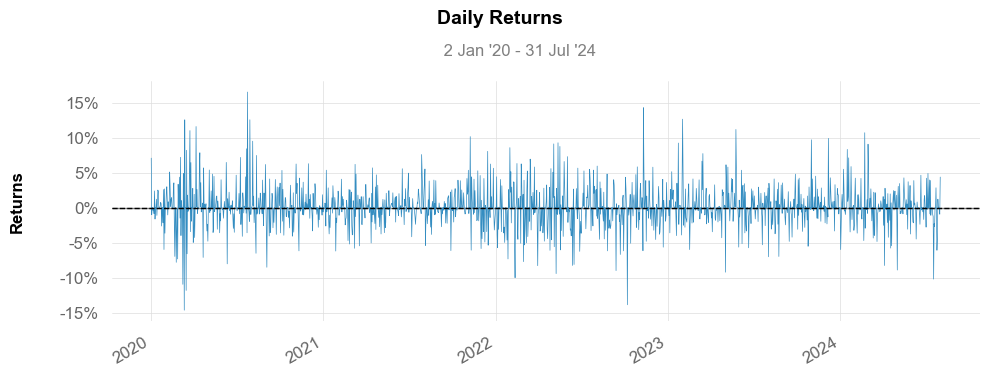

In [7]:
# You can replace this with an actual benchmark data series
benchmark = qs.utils.download_returns('SPY')  # SPY is an ETF that tracks the S&P 500
benchmark = benchmark.loc['2020-01-01':'2024-07-31']
benchmark.index = benchmark.index.tz_localize(None)

# Plotting Daily Returns for Apple with Benchmark
print('\nApple Daily Returns Plot:\n')
qs.plots.daily_returns(aapl, benchmark)

# Plotting Daily Returns for AMD with Benchmark
print('\nAMD Daily Returns Plot:\n')
qs.plots.daily_returns(amd, benchmark)


Apple Cumulative Returns Plot



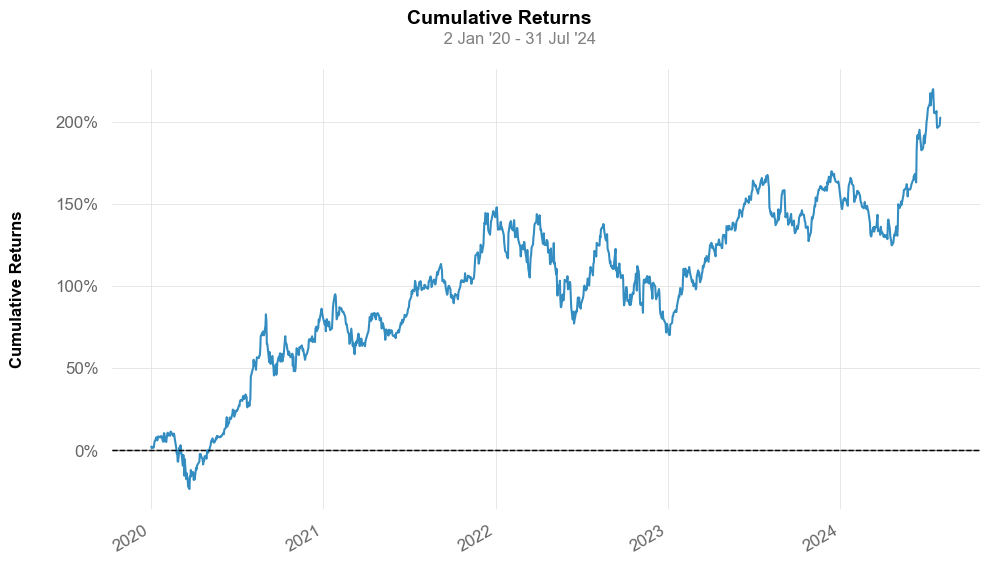


AMD Cumulative Returns Plot



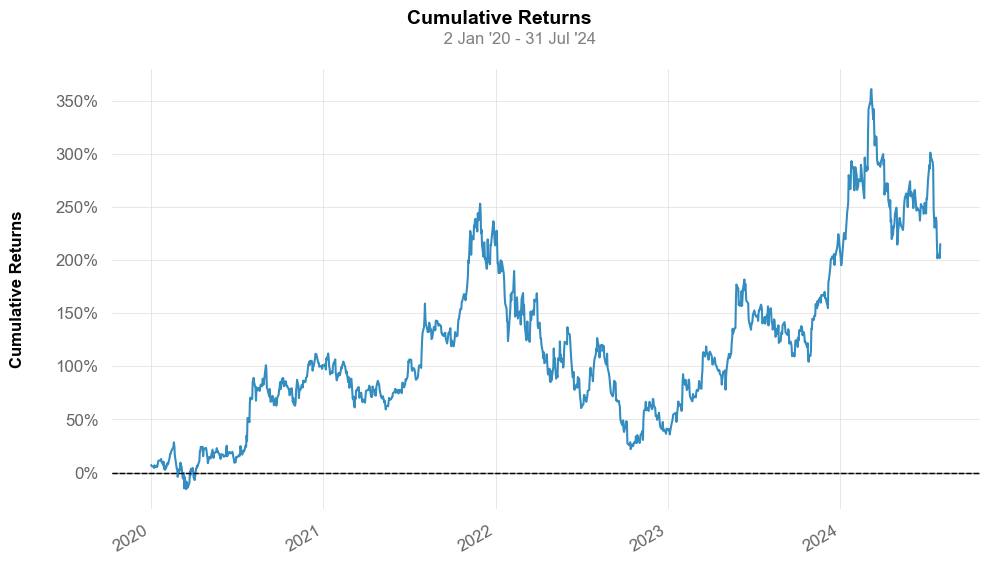

In [8]:
print('\nApple Cumulative Returns Plot\n')
qs.plots.returns(aapl)

print('\nAMD Cumulative Returns Plot\n')
qs.plots.returns(amd)

In [9]:
# Calculate the kurtosis
print("Apple's kurtosis: ", qs.stats.kurtosis(aapl).round(2))
print("AMD's kurtosis: ", qs.stats.kurtosis(amd).round(2))
print('\n')

# Calculate the skewness
print("Apple's skewness: ", qs.stats.skew(aapl).round(2))
print("AMD's skewness: ", qs.stats.skew(amd).round(2))
print('\n')

# Calculate the standard deviation
std_dev_aapl = round(aapl.std(), 3)
std_dev_amd = round(amd.std(), 3)

# Print the result
print("Apple's Standard Deviation:", std_dev_aapl)
print("AMD's Standard Deviation:", std_dev_amd)
print('\n')


Apple's kurtosis:  5.03
AMD's kurtosis:  2.11


Apple's skewness:  0.12
AMD's skewness:  0.2


Apple's Standard Deviation: 0.021
AMD's Standard Deviation: 0.034




In [10]:
# Merging daily returns into one dataframe
merged_df = pd.concat([aapl,amd], join = 'outer', axis = 1)
merged_df.columns = ['aapl', 'amd']
merged_df # Displaying dataframe

,aapl,amd
Date,,
2020-01-02 00:00:00+00:00,0.022816,0.070650
2020-01-03 00:00:00+00:00,-0.009722,-0.010183
2020-01-06 00:00:00+00:00,0.007968,-0.004321
2020-01-07 00:00:00+00:00,-0.004703,-0.002893
2020-01-08 00:00:00+00:00,0.016086,-0.008705
...,...,...
2024-07-25 00:00:00+00:00,-0.004805,-0.043629
2024-07-26 00:00:00+00:00,0.002161,0.012073
2024-07-29 00:00:00+00:00,0.001285,-0.001714


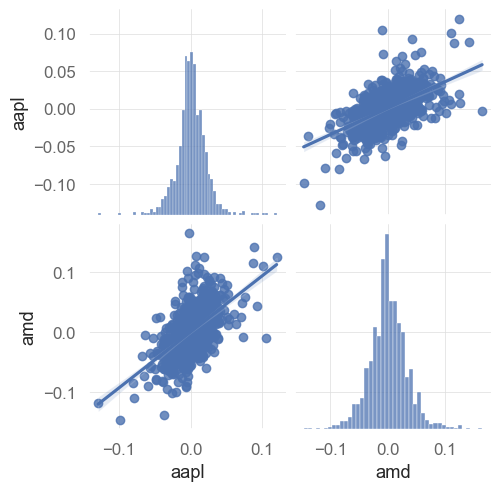

In [11]:
# Pairplots
sns.pairplot(merged_df, kind = 'reg')
plt.show()



In [12]:
from sklearn.linear_model import LinearRegression

# Download historical data for AAPL,AMD and SPY (S&P 500 ETF)
aapl = yf.download('AAPL', start='2020-01-01', end='2024-07-31')['Adj Close'].pct_change().dropna()
amd = yf.download('AMD', start='2020-01-01', end='2024-07-31')['Adj Close'].pct_change().dropna()
sp500 = yf.download('SPY', start='2020-01-01', end='2024-07-31')['Adj Close'].pct_change().dropna()

# Remove index (dates) and convert to NumPy arrays for regression
aapl_no_index = aapl.values
amd_no_index = amd.values
sp500_no_index = sp500.values

# Reshape the data to fit the linear regression model
X = sp500_no_index.reshape(-1, 1)
y_appl = aapl_no_index.reshape(-1, 1)
y_amd = amd_no_index.reshape(-1, 1)
# Fit the linear regression model
linreg_for_appl = LinearRegression().fit(X, y_appl)
linreg_for_amd = LinearRegression().fit(X, y_amd)

# Extract beta (slope) and alpha (intercept)
beta_aapl = linreg_for_appl.coef_[0]
alpha_aapl = linreg_for_appl.intercept_
# Extract beta (slope) and alpha (intercept)
beta_amd = linreg_for_amd.coef_[0]
alpha_amd = linreg_for_amd.intercept_

# Print the beta and alpha values, rounded to 3 decimal places
print('\nAAPL beta: ', beta_aapl.round(3))
print('\nAAPL alpha: ', alpha_aapl.round(3))

# Print the beta and alpha values, rounded to 3 decimal places
print('\nAMD beta: ', beta_amd.round(3))
print('\nAMD alpha: ', alpha_amd.round(3))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL beta:  [1.208]

AAPL alpha:  [0.]

AMD beta:  [1.577]

AMD alpha:  [0.001]


In [13]:
print("Sharpe Ratio for AAPL: ", qs.stats.sharpe(aapl).round(2))
print("Sharpe Ratio for AMD: ", qs.stats.sharpe(amd).round(2))

Sharpe Ratio for AAPL:  0.9
Sharpe Ratio for AMD:  0.69


In [34]:
weights = [0.50, 0.50] # Defining weights for each stock
portfolio = aapl*weights[0] + amd*weights[1] # Creating portfolio multiplying each stock for its respective weight 
portfolio # Displaying portfolio's daily returns

Date
2020-01-03   -0.005092
2020-01-06   -0.002160
2020-01-07   -0.001447
2020-01-08   -0.004352
2020-01-09    0.011917
                ...   
2024-07-24   -0.030422
2024-07-25   -0.021814
2024-07-26    0.006037
2024-07-29   -0.000857
2024-07-30   -0.004687
Name: Adj Close, Length: 1150, dtype: float64

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2024-07-30   2024-07-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          78.8%        83.97%
CAGR﹪                     9.16%        9.63%

Sharpe                     0.7          0.9
Prob. Sharpe Ratio         92.98%       97.31%
Smart Sharpe               0.62         0.8
Sortino                    0.98         1.34
Smart Sortino              0.87         1.19
Sortino/√2                 0.69         0.95
Smart Sortino/√2           0.61         0.84
Omega                      1.17         1.17

Max Drawdown               -33.72%      -16.31%
Longest DD Days            708          499
Volatility (ann.)          21.52%       16.28%
R^2                        0.64         0.64
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-23,2020-05-19,97,-16.311004,-15.412510
2,2022-01-04,2023-01-05,2023-05-17,499,-15.547014,-14.723124
3,2020-09-02,2020-09-18,2020-12-24,114,-10.565039,-10.414645
4,2021-01-27,2021-03-08,2021-07-02,157,-9.633872,-8.207296
5,2023-12-15,2024-04-19,2024-06-06,175,-8.514218,-7.988230


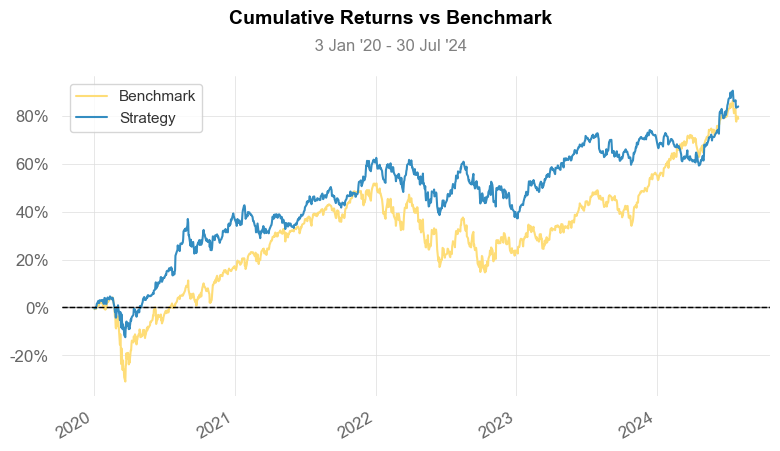

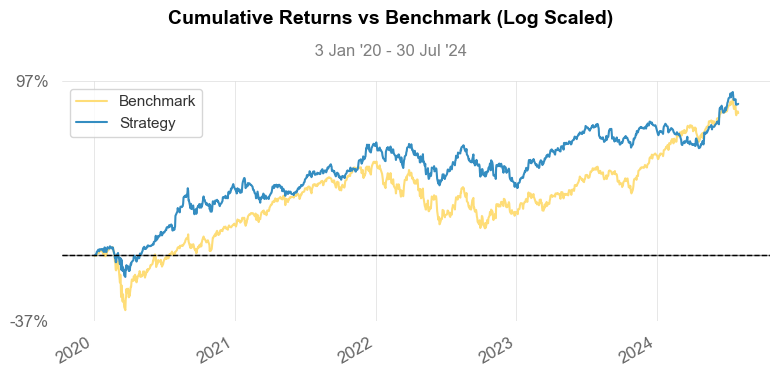

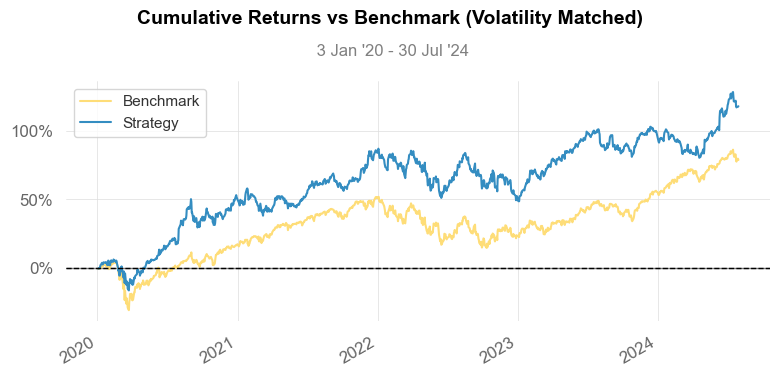

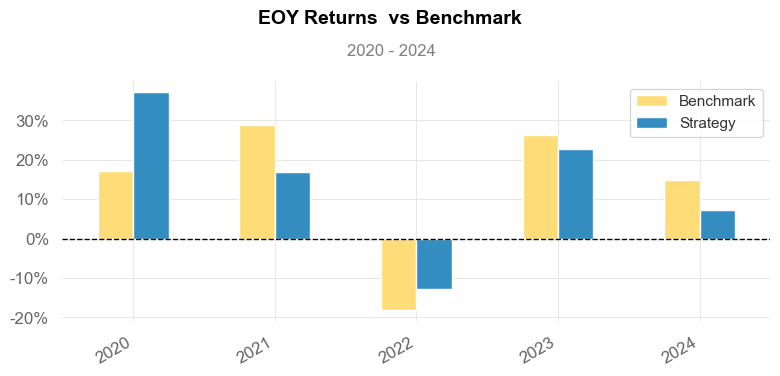

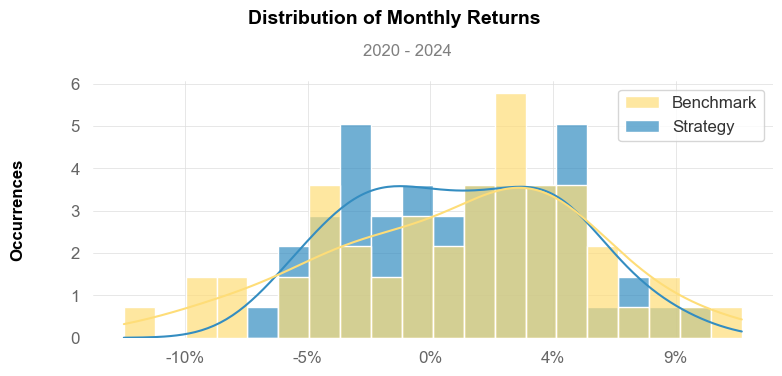

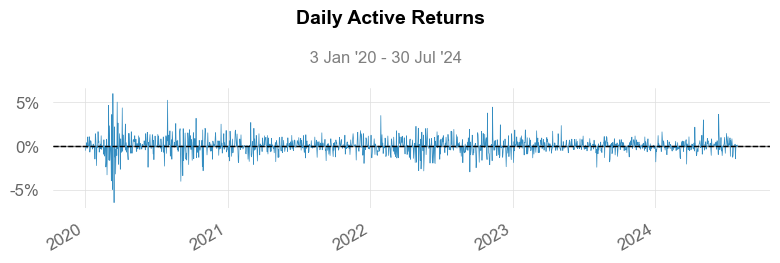

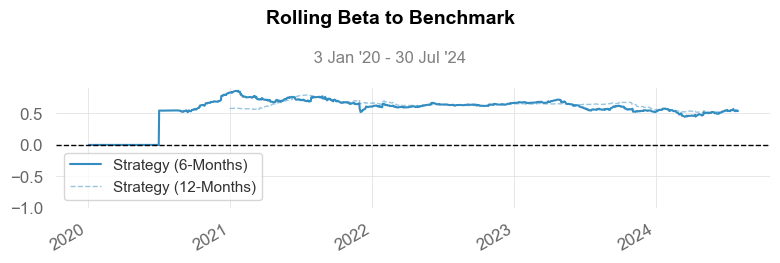

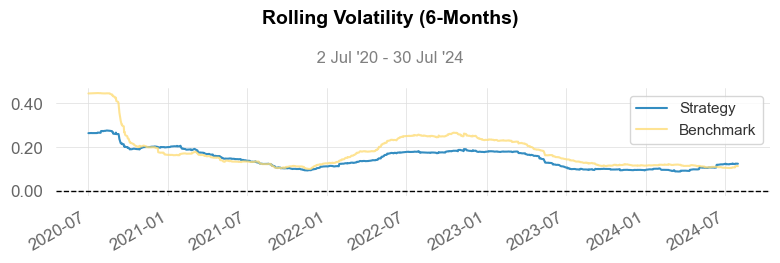

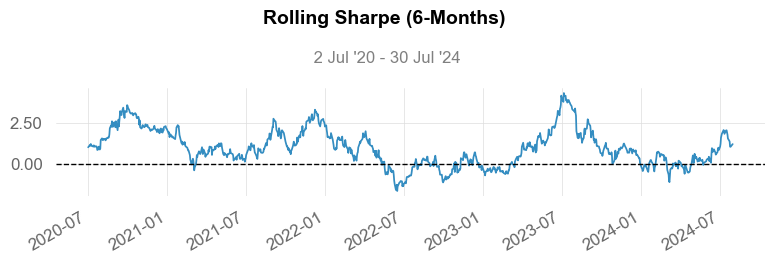

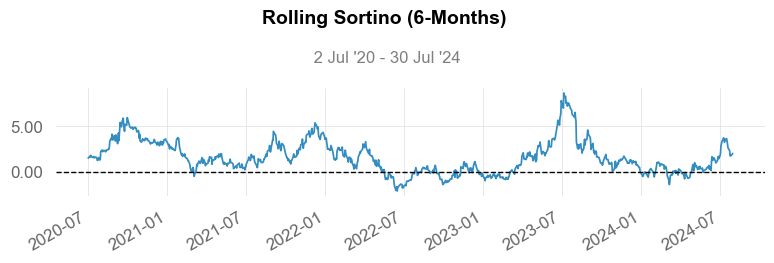

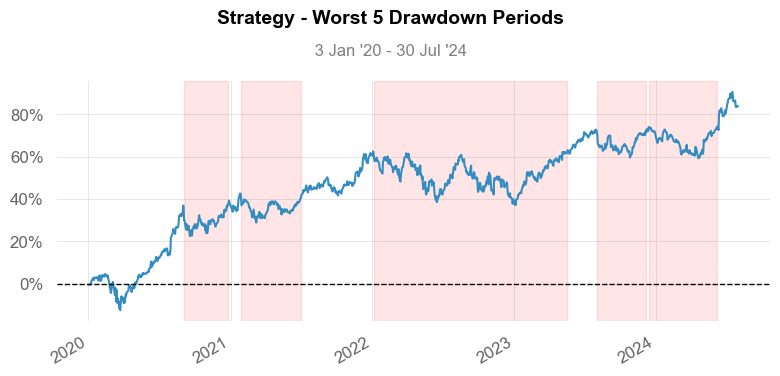

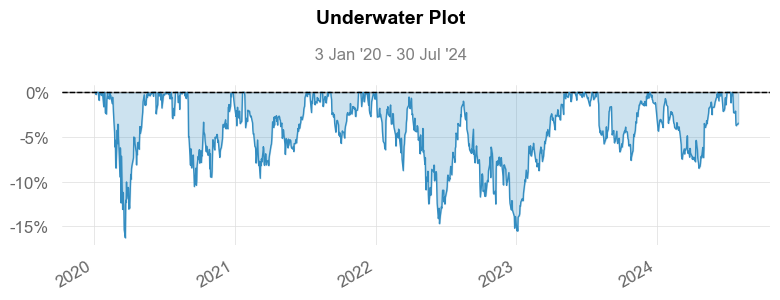

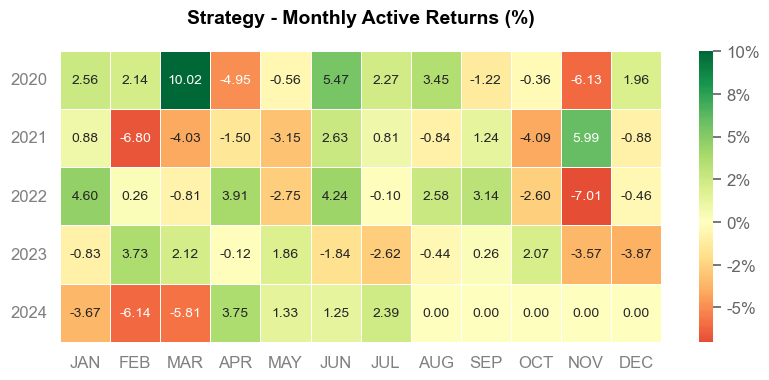

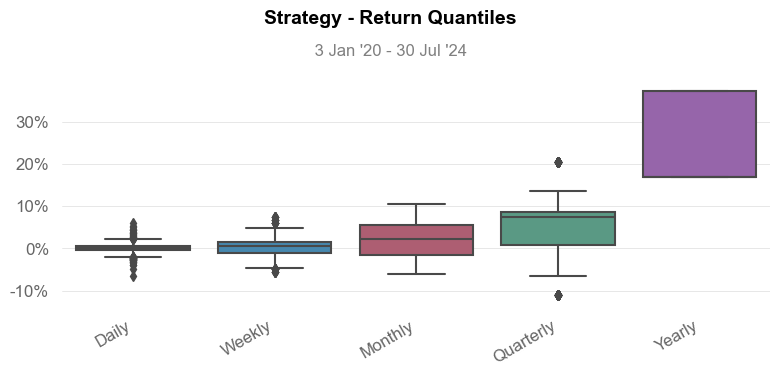

In [63]:
# Generating report on portfolio performance
qs.reports.full(portfolio, benchmark = sp500)

In [ ]:


# Prepare the data for predictive modeling
def prepare_data(data, feature_col='Adj Close', time_step=60):
    # Convert the dataframe to a numpy array
    data = data[feature_col].values.reshape(-1, 1)
    
    # Scale the data to range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Create the training dataset
    x_train, y_train = [], []
    for i in range(time_step, len(scaled_data)):
        x_train.append(scaled_data[i-time_step:i, 0])
        y_train.append(scaled_data[i, 0])
        
    # Convert to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # Reshape the data to be 3-dimensional [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the predictive model
def train_predictive_model(data, feature_col='Adj Close', time_step=60, epochs=10, batch_size=32):
    x_train, y_train, scaler = prepare_data(data, feature_col, time_step)
    model = build_lstm_model((x_train.shape[1], 1))
    
    # Train the model
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return model, scaler

# Predict future prices
def predict_future_prices(model, data, scaler, time_step=60, future_days=10):
    # Get the last time_step data points and scale it
    last_time_step_data = data[-time_step:].reshape(-1, 1)
    scaled_last_time_step_data = scaler.transform(last_time_step_data)
    
    # Prepare the input for the model
    x_input = scaled_last_time_step_data.reshape(1, time_step, 1)
    
    # Predict future prices
    predictions = []
    for _ in range(future_days):
        # Predict the next price
        predicted_price = model.predict(x_input)
        
        # Append the prediction to the list
        predictions.append(predicted_price[0, 0])
        
        # Update x_input by appending the predicted price (reshaped to 3D)
        predicted_price_reshaped = np.reshape(predicted_price, (1, 1, 1))
        x_input = np.append(x_input[:, 1:, :], predicted_price_reshaped, axis=1)
    
    # Inverse transform the predictions back to the original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    return predictions



# Example usage:

# Train the model using AAPL data
model, scaler = train_predictive_model(AAPL, 'Adj Close')

# Predict the next 10 days of prices
predicted_prices = predict_future_prices(model, AAPL['Adj Close'].values, scaler)

print("Predicted Prices for the next 10 days:")
print(predicted_prices)


In [26]:
# Adding Moving Averages
AAPL['SMA50'] = AAPL['Adj Close'].rolling(window=50).mean() # Simple 50-Period Moving Average
AAPL['SMA200'] = AAPL['Adj Close'].rolling(window=200).mean() # Simple 200-Period Moving Average

AAPL.tail(10)

,Open,High,Low,Close,Adj Close,Volume,SMA50,SMA200
Date,,,,,,,,
2024-08-02,219.149994,225.600006,217.710007,219.860001,219.605804,105568600,212.353602,189.013722
2024-08-05,199.089996,213.500000,196.000000,209.270004,209.028061,119548600,212.720578,189.177621
2024-08-06,205.300003,209.990005,201.070007,207.229996,206.990402,69660500,213.127107,189.337849
2024-08-07,206.899994,213.639999,206.389999,209.820007,209.577423,63516400,213.523448,189.512903
2024-08-08,213.110001,214.199997,208.830002,213.309998,213.063385,47161100,213.989309,189.718220
2024-08-09,212.100006,216.779999,211.970001,216.240005,215.990005,42201600,214.507709,189.937574
2024-08-12,216.070007,219.509995,215.600006,217.529999,217.529999,38028100,215.036933,190.162439
2024-08-13,219.009995,221.889999,219.009995,221.270004,221.270004,44155300,215.621778,190.417645
2024-08-14,220.570007,223.029999,219.699997,221.720001,221.720001,41888500,216.180065,190.696043


In [44]:
# Plotting candlestick chart without indicators
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights = [0.7, 0.3])
fig.add_trace(go.Candlestick(x=AAPL.index,
                             open=AAPL['Open'],
                             high=AAPL['High'],
                             low=AAPL['Low'],
                             close=AAPL['Adj Close'],
                             name='AAPL'),
              row=1, col=1)

# Plotting volume chart on the second row 
fig.add_trace(go.Bar(x=AAPL.index,
                     y=AAPL['Volume'],
                     name='Volume',
                     marker=dict(color='blue', opacity=1.0)),
              row=2, col=1)

fig.add_trace(go.Scatter(x=AAPL.index,
                         y=AAPL['SMA50'],
                         mode='lines',
                         line=dict(color='orange'),
                         name='SMA50'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=AAPL.index,
                         y=AAPL['SMA200'],
                         mode='lines',
                         line=dict(color='red'),
                         name='SMA200'),
              row=1, col=1)

# Plotting annotation
fig.add_annotation(text='Apple (AAPL)',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)

# Configuring layout
fig.update_layout(title='AAPL Candlestick Chart',
                  yaxis=dict(title='Price (USD)'),
                  height=1000,
                 template = 'plotly_white')

# Axes and subplots
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
fig.update_xaxes(rangeslider_visible=False, row=4, col=1)
fig.update_yaxes(title_text='Price (USD)', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=4, col=1)

fig.show()

In [47]:
print(AAPL.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA50',
       'SMA200'],
      dtype='object')


In [62]:
# Define a function to check SMA crossovers and send alerts
def check_sma_crossover(data):
    alerts = []
    
    if 'Adj Close' not in data.columns:
        print("Error: 'Adj Close' column is missing from the DataFrame.")
        return alerts

    # Print the last few rows to debug
    #print(data.tail(60))  # Adjust the number if needed to see the SMA columns

    # Detect crossover
    if len(data) >= 200:  # Ensure there's enough data
        crossover = data['SMA50'].iloc[-2] < data['SMA200'].iloc[-2] and data['SMA50'].iloc[-1] > data['SMA200'].iloc[-1]
        crossunder = data['SMA50'].iloc[-2] > data['SMA200'].iloc[-2] and data['SMA50'].iloc[-1] < data['SMA200'].iloc[-1]

        if crossover:
            alerts.append("AAPL: SMA50 has crossed above SMA200.")
        elif crossunder:
            alerts.append("AAPL: SMA50 has crossed below SMA200.")
    else:
        alerts.append("Not enough data to calculate SMAs.")
    
    return alerts

# Check for alerts
alerts = check_sma_crossover(AAPL)
print("Alerts generated")

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email_alert(alerts):
    if len(alerts) > 0:
        try:
            # Email setup
            sender_email = 'khatodeabhijeet@gmail.com'
            recipient_email = 'khatodeabhijeet@gmail.com'
            password = 'kcvq kyhs nppm qqhi'  # Your app-specific password

            # Create the email
            subject = 'Alert'
            body = "\n".join(alerts)
            message = MIMEMultipart()
            message['From'] = sender_email
            message['To'] = recipient_email
            message['Subject'] = subject
            message.attach(MIMEText(body, 'plain'))

            # Connect to the SMTP server
            server = smtplib.SMTP('smtp.gmail.com', 587)
            server.starttls()
            server.login(sender_email, password)
            server.send_message(message)
            server.quit()

            print("Email Alert Sent")

        except smtplib.SMTPAuthenticationError as e:
            print("Authentication Error: Check your email and app-specific password.")
            print(e)
        except smtplib.SMTPException as e:
            print("SMTP Error: Check your SMTP configuration.")
            print(e)
        except Exception as e:
            print("An error occurred:")
            print(e)

alerts = [
    "AAPL: SMA50 has crossed above SMA200.
]

send_email_alert(alerts)


Alerts generated
